# Statistical Methods - Assessment 4
## CID: 01876355

### Section - 1: Data Pre-processing
Let us begin our analysis by loading in the necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numba import jit
import random as rd
from time import time
import plotly.graph_objects as go

We have imported only standard libraries here. We have also imported `numba` which provides a just-in-time (JIT) compiler. The compiler allows for significantly faster execution of code consisting of loops and `numpy` arrays, both of which we will be using extensively in our analysis.

We will be working with covariance matrices in our analysis. However, the data for this is stored as a 1D array, instead of a matrix, so we should check if we obtain valid covariance matrices when reshaping/resizing the data:

In [2]:
def cov_val(matrix):
    """
    Check if a given matrix is a valid covariance matrix.
    The matrix must satisfy the following conditions:

    - Be a square matrix
    - Be symmetric
    - Be positive semi-definite
    - All entries are finite
    - Main diagonal must contain only positive values (variances are positive)

    The conditions can be stated differently, but we will use these.
    """

    # Square matrix check:
    if matrix.shape[0] != matrix.shape[1]:
        print('Matrix is not square.')
        return False
        
    # Symmetry check (upto small tolerance):
    if not sp.linalg.issymmetric(cov_data_matrix, atol = 1e-7):
        print('Matrix is not symmetric.')
        return False
        
    # Positive semi-definite check
    if np.any(np.linalg.eigvals(matrix) < 0):
        print('Matrix is not positive semi-definite.')
        return False

    # Check is all the entries are finite
    if not np.all(np.isfinite(matrix)):
        print('Matrix does not contain only finite values.')
        return False

    # Check is the diagonal has only posiitve values  
    if not np.all(matrix.diagonal() > 0):
        print('Matrix diagonal can only contain positive values.')
        return False

    print('Matrix is a valid covariance matrix.')
    return True

We can now load in the necessary files, which were saved locally:

In [3]:
file_name_1 = 'Pantheon+SH0ES_STAT+SYS.cov.txt'
file_name_2 = 'Pantheon+SH0ES.dat'

In [4]:
overall_data = pd.read_csv(file_name_2, sep=r'\s+')

# Discard entries in the overall dataset with zHD < 0.01, i.e. retain those with zHD >= 0.01
overall_data_filt = overall_data[overall_data['zHD']>=0.01]

# Also remove other columns that are not needed here
cols_retain = ['zHD', 'MU_SH0ES'] # Redshifts, distance moduli ('0' not 'O')
overall_data_filt = overall_data_filt[cols_retain]

In [5]:
display(overall_data_filt)
overall_data_filt.reset_index(inplace = True)

zHD  MU_SH0ES
111   0.01016   32.7794
112   0.01017   32.9182
113   0.01017   32.9674
114   0.01026   33.3378
115   0.01026   33.2253
...       ...       ...
1696  1.61505   45.1595
1697  1.69706   45.2863
1698  1.80119   45.4865
1699  1.91165   45.4233
1700  2.26137   46.1828

[1590 rows x 2 columns]

In [6]:
cov_data = np.loadtxt(file_name_1, skiprows = 1)

# cov_data is a list of numbers, but we need an n-by-n matrix
cov_data_matrix = np.reshape(cov_data, newshape = (len(overall_data), len(overall_data)))

# Check if the matrix we generated is Let
# a valid covariance matrix
print('Covariance Matrix: \n')
print(cov_data_matrix)
print('\n')
cov_val(cov_data_matrix)

Covariance Matrix: 

[[ 3.177108e-02  5.754430e-03  3.100600e-04 ...  2.945500e-04
  -8.595000e-05 -2.701100e-04]
 [ 5.754430e-03  3.456656e-02  6.595500e-04 ... -2.863200e-04
  -2.456300e-04 -2.363400e-04]
 [ 3.100600e-04  6.595500e-04  6.125745e-02 ...  1.936450e-03
   3.214810e-03  4.000510e-03]
 ...
 [ 2.945500e-04 -2.863200e-04  1.936450e-03 ...  4.157373e-02
   4.902260e-03  5.887030e-03]
 [-8.595000e-05 -2.456300e-04  3.214810e-03 ...  4.902260e-03
   6.742823e-02  8.751110e-03]
 [-2.701100e-04 -2.363400e-04  4.000510e-03 ...  5.887030e-03
   8.751110e-03  4.499005e-02]]


Matrix is a valid covariance matrix.


True

Now, we only consider last 1590 entries from the overall dataset, i.e. we need to remove the first 111 rows from it. We need to resize our covariance matrix to account for this. We can achieve this by slicing the generated matrix appropriately and checking if it is still a valid covariance matrix.

In [7]:
cov_mat_filt = cov_data_matrix[111:, 111:]
print('Reduced covariance matrix: \n')
print(cov_mat_filt)
print('\n')
print(cov_val(cov_mat_filt))

Reduced covariance matrix: 

[[ 0.06543689 -0.00083541 -0.00124244 ... -0.00077386 -0.00075876
  -0.0006363 ]
 [-0.00083541  0.06930601  0.02413895 ...  0.0002077   0.00156451
   0.00183639]
 [-0.00124244  0.02413895  0.0592691  ...  0.00091788  0.00204978
   0.00249542]
 ...
 [-0.00077386  0.0002077   0.00091788 ...  0.04157373  0.00490226
   0.00588703]
 [-0.00075876  0.00156451  0.00204978 ...  0.00490226  0.06742823
   0.00875111]
 [-0.0006363   0.00183639  0.00249542 ...  0.00588703  0.00875111
   0.04499005]]


Matrix is a valid covariance matrix.
True


### Section - 2: Preliminary Analysis

Now that we have the data formatted in an appropriate manner, we define some variables and constants that will be used to perform the calculations detailed in the theory section.

In [8]:
c = 3e5 # Speed of light (in km s^{-1})
# Hubble constant factored out, so no dependence of D_{L} == D*_{L} on h
H_0 = 100 # density in Hubble constant (h = 1 here) (in km s^{-1} Mpc^{-1})

# Need to use uniform priors for h and omega_m
# Define some bounds for these
# More explanation to follow
min_h, max_h = 0.0, 10.0
min_omega_m, max_omega_m = 0.0, 10.0

z = overall_data_filt['zHD'].to_numpy()
mu = overall_data_filt['MU_SH0ES'].to_numpy()
cov_matrix = cov_mat_filt.copy()
cov_inv = np.linalg.inv(cov_matrix)

We also define functions that will allow us to perform the necessary simulations and calculations using these values. We need to write functions to calculate: $D_{L}(z)$, $\eta(a, \Omega_m)$, and $\mu_{th}$, i.e. the theoretical distance modulus.

In [9]:
@jit(nopython = True)
def eta(a, omega_m):
    """
    Converts the mathematical form of eta(a, omega_m) 
    from the theory section into code.
    """
    
    
    s = np.cbrt((1 - omega_m)/omega_m)
    eta_func = 2 * np.sqrt(s**3 + 1) * (
        1 / a ** 4 - 
        0.1540 * (s/a ** 3) + 
        0.4304 * (s ** 2 / a ** 2) + 
        0.19097 * (s ** 3 / a) + 
        0.066941 * (s ** 4)
    ) ** (-1/8)
    
    return eta_func

@jit(nopython = True)
def D_L_star(z, omega_m):
    """
    Computes the theoretical luminosity distance (D_L*) in Mpc.
    Assumes a flat universe.
    """
        
    D_L_star = (c/H_0) * (1+z) * (eta(1, omega_m) - eta((1/(1+z)), omega_m))
    
    return D_L_star

@jit(nopython = True)
def mu_th(z, h, omega_m):
    """
    Computes the theoretical distance modulus, mu_th.
    """
    D_L = D_L_star(z, omega_m)
    return 25 - 5 * np.log10(h) + 5 * np.log10(D_L)

Let us perform some sanity checks with these functions with some arbitrary values for $h$ and $\Omega_m$, and visualise their outputs to see if they return sensible results:

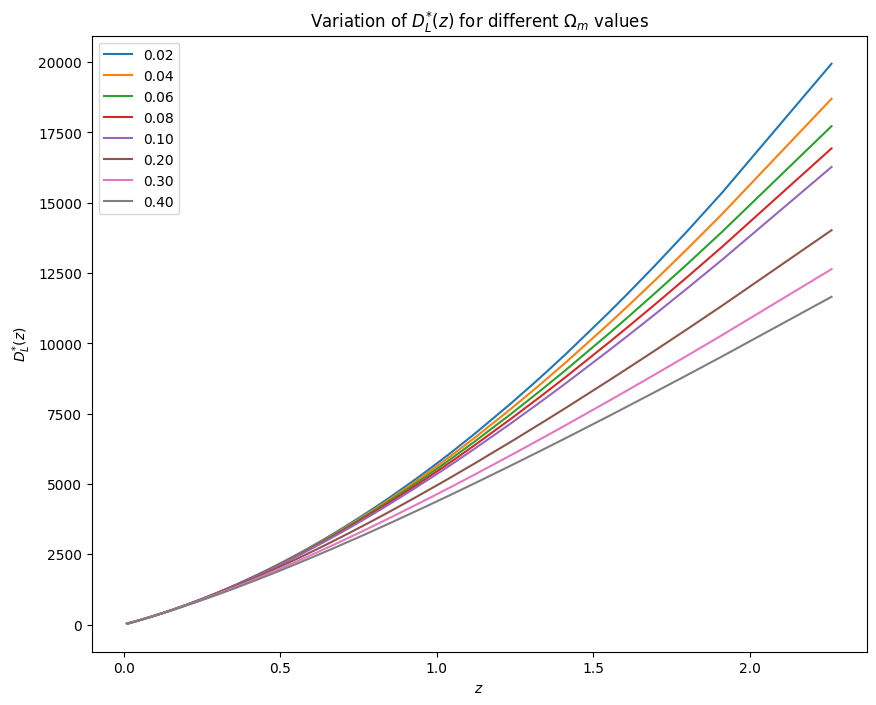

In [10]:
params_list = [(0.02*i, 0.02*i) for i in range(1,5)] + [(0.1*i, 0.1*i) for i in range(1,5)] #Arbitrary input parameters
plt.figure(figsize = (10,8))
plt.title(r'Variation of $D^{*}_{L}(z)$ for different $\Omega_{m}$ values')
plt.ylabel(r'$D^{*}_{L}(z)$')
plt.xlabel(r'$z$')
for params in params_list:
    h, omega_m = params
    lum_dist = D_L_star(z, omega_m)
    plt.plot(z, lum_dist, label = f'{omega_m:.2f}')
plt.legend()
plt.show()
plt.close()

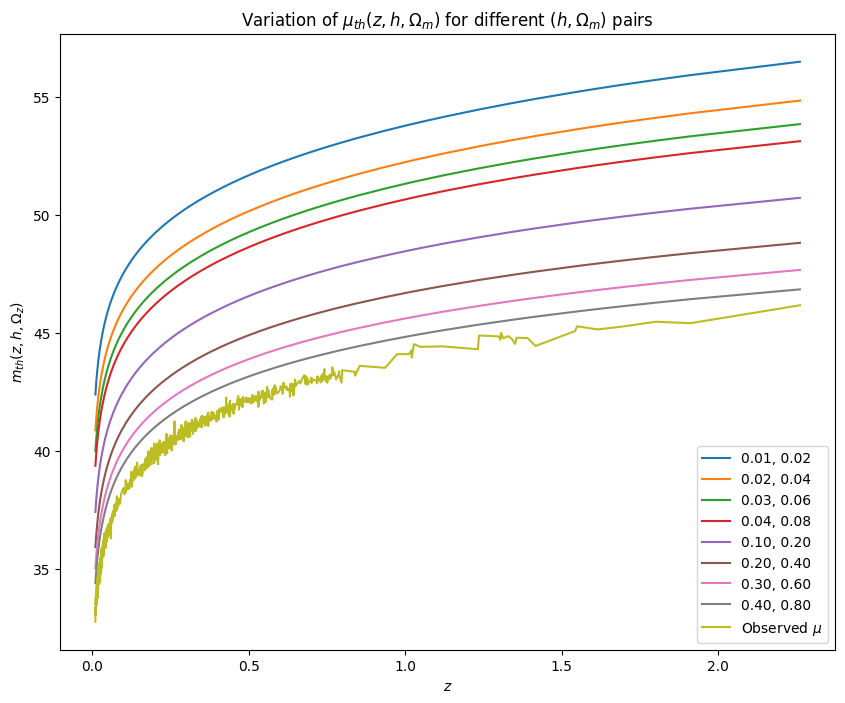

In [11]:
params_list = [(0.01*i, 0.02*i) for i in range(1,5)] + [(0.1*i, 0.2*i) for i in range(1,5)]

plt.figure(figsize = (10,8))
plt.title(r'Variation of $\mu_{th}(z, h, \Omega_{m})$ for different $(h, \Omega_{m})$ pairs')
plt.ylabel(r'$m_{th}(z, h, \Omega_{z})$')
plt.xlabel(r'$z$')
for params in params_list:
    h, omega_m = params
    mu_theory = mu_th(z, h, omega_m)
    plt.plot(z, mu_theory, label = f'{h:.2f}, {omega_m:.2f}')
plt.plot(z , mu, label = r'Observed $\mu$')
plt.legend()
plt.show()
plt.close()

The order of the values in the legend above follows $(h, \Omega_{m})$.

Now that we have an idea of the scales of values we are dealing with and their behaviour, we can proceed to construct a framework to perform Hamiltonian Monte Carlo (HMC) to infer the values of $h$ and $\Omega_{m}$.

We note that we will be sampling from the likelihood function, as noted in the question. We expect that the probability of finding the parameter values outside the range of say (0,10) should be negligible, since, as mentioned in the quetsion, the parameters are of order unity. This explains our earlier choices of `h_min, h_max` and `omega_m_min, omega_m_max`.

We first define NLL, i.e, the negative log of the likelihood function/target distribution (uniform priors used, so they mean the same thing here), which will serve as the potential in our HMC algorithm. 

In [12]:
@jit(nopython = True)
def nll_target(z, mu, priors):
    """
    Return the log of the posterior distribution
    detailed in the theory section.
    
    NOTE: 'Priors' - refers to the (current) parameter values 
                     (array of [h, Omega_m])
    """
    
    h, omega_m = priors
    
    # Check if the samples of the priors are within the bounds
    # set for the priors. Else, enforce prior bounds as -np.inf.
    if not (min_h < h < max_h and min_omega_m < omega_m < max_omega_m):
        return -np.inf # Rejected by HMC

    # Calculate theoretical distance modulus for all values of z
    theory_mu = mu_th(z, h, omega_m)

    # Calculate the residual delta_mu vector
    delta_mu = mu-theory_mu

    # NLL, so negate
    result = 0.5 * (delta_mu.T @ cov_inv @ delta_mu)

    return result

Let us check the behaviour of this function as well. We know that the NLL depends on pairs of values $(h, \Omega_m)$, so we check the behaviour of this function in 3D.

In [13]:
h_values = np.linspace(0.1, 10, 100, endpoint = False)
omega_m_values = np.linspace(0.1, 10, 100, endpoint = False)
h, omega_m = np.meshgrid(h_values, omega_m_values)
flat_h = h.flatten()
flat_omega_m = omega_m.flatten()

nll_flat = np.array([
    nll_target(z, mu, (h_val, omega_m_val))
    for h_val, omega_m_val in zip(flat_h, flat_omega_m)
])

nll = nll_flat.reshape(h.shape)

# Plot the surface
fig = go.Figure(data=[go.Surface(z=nll, x=h, y=omega_m)])

fig.update_layout(
    title='3D Plot of: NLL(h, Omega_m)',
    scene=dict(
        xaxis_title='h',
        yaxis_title='Omega_m',
        zaxis_title='NLL'
    ),
    width=800,
    height=800
)

fig.show()

Given this surface plot, we have a rough idea of where the minimum of the negative log-likelihood function is, which is somehwere in the range of (0,1] for both parameters. In fact, we can calculate it, and use these values of $(h, \Omega_m)$ as "benchmark values" going forward:

In [14]:
min_value = np.min(nll)
# Find the indices of the maximum value in the Z array
min_index = np.unravel_index(np.argmin(nll), nll.shape)

# Extract the corresponding h, omega_m coordinates
min_hubble = h[min_index]
min_mass = omega_m[min_index]

print(f"Minimum NLL: {min_value}")
print(f"At h = {min_hubble:.3f}, Omega_m = {min_mass:.3f}")

Minimum NLL: 838.5516004101072
At h = 0.694, Omega_m = 0.595


Next, we will need to define a function that calculates the gradient of the NLL for use in the leapfrog algorithm. Since we are estimating two parameters, we will need to ensure that we are performing partial derivatives with respective to each, while keeping the other parameter constant. 

These partial deriavtives will be collected in the `grad` vector, which would essentially be the same as $\nabla U(\theta)$, where $U(\theta)$ is the scalar potential function ($\equiv$ to our NLL) of $\theta$, which is a vector of parameters (here $(h, \Omega_{m})$).

For calculating derivatives, we will use the central difference approximation, which is numerically more stable, but more computationally expensive, than the forward/backward difference approximations used in numerical integration schemes. The use of a JIT in our application should mitigate the slow down in execution to a noticeable extent.

In [15]:
@jit(nopython=True)
def grad_lg_post(z, mu, priors):
    """
    Computes the gradient of the log-posterior for parameters, here [h, Omega_m].
    Uses central difference approximation for partial derivatives.
    
    Returns:
        grad (array): Gradient vector [d(log_target)/dh, d(log_target)/d(Omega_m)].
    """
    grad = np.zeros_like(priors)  # Gradient vector for [h, Omega_m]

    for i in range(len(priors)):
        priors_perturb_plus = np.copy(priors)
        priors_perturb_minus = np.copy(priors)

        # Can adjust, depending on how 'local' a gradient
        # calculation is required
        priors_perturb_plus[i] =  1.1 * priors_perturb_plus[i]
        priors_perturb_minus[i] = 0.9 * priors_perturb_minus[i]
        diff = priors_perturb_plus[i] - priors_perturb_minus[i]

        # Central difference approximation of partial derivative
        # w.r.t to the i-th parameter
        grad[i] = (nll_target(z, mu, priors_perturb_plus) - nll_target(z, mu, priors_perturb_minus)) / (2 * diff)
    return grad

Let us also check the behaviour of this function, within the range of parameter values we identified earlier.

In [16]:
h_values = np.linspace(0.1, 1, 100, endpoint = False)
omega_m_values = np.linspace(0.1, 1, 100, endpoint = False)
h, omega_m = np.meshgrid(h_values, omega_m_values)

eps = 1e-4

flat_h = h.flatten()
flat_omega_m = omega_m.flatten()
grad_nll_flat = np.array([
    grad_lg_post(z, mu, np.array([h_val, omega_m_val]))
    for h_val, omega_m_val in zip(flat_h, flat_omega_m)
])

grad_norm_flat = np.linalg.norm(grad_nll_flat, axis=1)

grad_norm = grad_norm_flat.reshape(h.shape)

fig = go.Figure(data=[go.Surface(z=grad_norm, x=h, y=omega_m)])

fig.update_layout(
    title='3D Plot of Gradient Norm of NLL(h, Omega_m)',
    scene=dict(xaxis_title='h',
               yaxis_title='Omega_m',
               zaxis_title='||Grad(NLL)||'),
    width=800,
    height=800
)

fig.show()

We can also find where the gradient becomes be zero, which should be at a point near the minimum found before. We can approximate the point where the gradient is zero by finding the point on the surface which is closest to zero.

In [17]:
min_grad = np.min(grad_norm) # same as grad_diff_0 = grad_norm - 0
min_index = np.unravel_index(np.argmin(grad_norm), grad_norm.shape)

min_hubble = h[min_index]
min_mass = omega_m[min_index]

print(f"Minimum gradient: {min_grad}")
print(f"At h = {min_hubble:.3f}, Omega_m = {min_mass:.3f}")

Minimum gradient: 150.73819741823797
At h = 0.748, Omega_m = 0.244


### Section - 3:  Simulation-based Bayesian Inference Framework
We are now in a position to construct a framework for simulation-based inference of the required parameters using the Hamiltonian Monte Carlo (HMC) algorithm, which incorporates a leapfrog integrator.

The leapfrog algorithm is critical for the HMC method because it ensures two key properties of Hamiltonian dynamics:

- Symmetry (Time-Reversibility): The algorithm ensures that the sequence of updates can be reversed without introducing bias into the sampling process.
- Symplecticity (Volume Preservation): The algorithm preserves the volume of phase space, ensuring that the probability density remains consistent under Hamiltonian evolution.

To implement the leapfrog integrator, we follow a sequence of updates:

1) Perform an initial half-step update to the momentum variables.
2) Alternate between full-step updates for position and momentum variables.
3) Conclude with a final half-step update to the momentum variables.

This sequence ensures that the leapfrog algorithm maintains symmetry and symplecticity, which are crucial for accurate sampling.

To verify the correctness of our implementation, we define a function that performs a "full-circuit" test. Starting from a given set of phase space coordinates, the algorithm should return to the same coordinates when the sequence of updates is run forward and then reversed. This test ensures that the leapfrog algorithm fulfills the required criteria for use in HMC.

In [18]:
@jit(nopython = True)
def leapfrog_alg(z, mu, p, q, step_size, num_steps):
    """
    Implements the leapfrog algorithm.

    We use 'q' to refer to the initial position in phase space, which corresponds 
    to the parameters of the target distribution (here: h, omega_m).

    We use 'p' to represent the initial momentum, an auxiliary 
    variable introduced in HMC to explore the parameter space more effectively. 
    
    The algorithm allows us to use Hamilton's equations of motion to simulate 
    trajectories in phase space.

    Here, we perform alternate updates to 'q' (position) and 'p' (momentum) 
    to approximate the trajectory defined by the Hamiltonian dynamics. 
    
    This ensures reversibility and volume preservation, 
    which are essential for MCMC.
    """

    # Work with copies of momentum and position
    # Avoids changes to inputs directly
    p = np.copy(p)
    q = np.copy(q)
    
    # Half-step momentum update
    p -= 0.5 * step_size * grad_lg_post(z, mu, q)
    
    # Full-step updates
    for i in range(num_steps):
        # Position update
        q += step_size*p
        
        # skip final momentum update, ensure symmetry
        if i < num_steps - 1:
            p -= step_size * grad_lg_post(z, mu, q)

    # Final half-step momentum update
    p -= 0.5 * step_size * grad_lg_post(z, mu, q)
    return q,-p

def check_symmetry_leapfrog(z, mu, p_initial, q_initial, step_size, num_steps):
    """
    Function to test if the leapfrog algorithm has been correctly implemented.
    We want the final and initial phase space coordinates to match (upto some tolerance).
    """
    #print(f'Initial coordinates: {q_initial}, initial momenta: {p_initial}\n')
    
    #print("Running forward leapfrog...")
    q_forward, p_forward = leapfrog_alg(z, mu, p_initial, q_initial, step_size, num_steps)
    #print(f'Forward leapfrog - coordinates: {q_forward}, momenta: {p_forward}\n')
    
    #print("Running reverse leapfrog...")
    q_reverse, p_reverse = leapfrog_alg(z, mu, p_forward, q_forward, step_size, num_steps)
    #print(f'Reverse leapfrog - coordinates: {q_reverse}, momenta: {p_reverse}\n')
    
    q_is_symmetric = np.allclose(q_initial, q_reverse, atol=1e-6)
    p_is_symmetric = np.allclose(p_initial, p_reverse, atol=1e-6)
    
    return q_is_symmetric, p_is_symmetric

We can check if our leapfrog algorithm works over an entire grid of initial phase space coordinates here:

In [19]:
# Define grid for q and p
q_values = np.linspace(0.1, 1.0, 10, endpoint = False)  # Example range for q
p_values = np.linspace(-50, 50, 10, endpoint = False)  # Example range for p

# Create meshgrid for q and p
q1, q2 = np.meshgrid(q_values, q_values)
p1, p2 = np.meshgrid(p_values, p_values)

# Flatten the grid to iterate over pairs
q_grid = np.array([q1.flatten(), q2.flatten()]).T
p_grid = np.array([p1.flatten(), p2.flatten()]).T

# Leapfrog parameters
step_size = 1e-5 # Why array? More on this later
num_steps = 10

# Test symmetry over the grid
results = []
for i, (q_initial, p_initial) in enumerate(zip(q_grid, p_grid)):
    q_symmetric, p_symmetric = check_symmetry_leapfrog(z, mu, p_initial, q_initial, step_size, num_steps)
    results.append((q_initial, p_initial, q_symmetric, p_symmetric))

    if not(q_symmetric and p_symmetric):
        print(f"Not symmetric for q={q_initial}, p={p_initial}. Iteration:{i}")

# Summarize results
num_symmetric = sum(q_sym and p_sym for _, _, q_sym, p_sym in results)
total_tests = len(results)
print(f"Symmetry passed in {num_symmetric}/{total_tests} tests.")

Symmetry passed in 100/100 tests.


This is sufficient indication that our leapfrog algorithm is working properly, though the values $p$ may fall outside the range we have considered here.

Lastly, we need to construct a function that performs the HMC simulation and returns samples of $(h, \Omega_m)$. We will follow the structure in the notes for the most part.

In [20]:
@jit(nopython=True)
def exe_HMC(z, mu, initial_params, n_samples, step_size, num_steps,
            target_acceptance=0.7, adaptive_steps = True, adapt_interval=100):
    """
    Implements the HMC algorithm for sampling the target distribution.
    """
    num_accept = 0
    interval_accept = 0
    samples = np.zeros(shape=(n_samples, len(initial_params)))
    q = initial_params  # array of initial params: [h, omega_m]
    samples[0] = q
    
    acceptance_list = np.zeros(shape = (n_samples//adapt_interval))
    acceptance_list[0] = 0
    
    step_size_list = np.zeros(shape = (n_samples//adapt_interval))
    step_size_list[0] = step_size
    
    for i in range(1, n_samples):
        # Sample random momentum
        p = np.array([rd.gauss(0, 1), rd.gauss(0, 1)]) 
        
        # Calculate energy before leapfrog
        energy_before = nll_target(z, mu, q) + 0.5 * np.dot(p, p)
        
        # Perform leapfrog updates
        q_new, p_new = leapfrog_alg(z, mu, p, q, step_size, num_steps)
        
        # Calculate energy after leapfrog
        energy_after = nll_target(z, mu, q_new) + 0.5 * np.dot(p_new, p_new)
        
        # Calculate acceptance probability
        energy_diff = energy_before - energy_after
        accept_prob = np.exp(energy_diff)
        
        # Metropolis criterion
        if rd.uniform(0, 1) < min(1, accept_prob):
            num_accept += 1
            interval_accept += 1
            q = q_new  # Accept the new coordinates
        samples[i] = q

        # Adaptive leapfrog step size adjustment (optional)
        if adaptive_steps:
            if i % adapt_interval == 0:
                interval_ratio = interval_accept/adapt_interval
                acceptance_list[i//adapt_interval] = interval_ratio
                #print('Iteration:', i, '. Ratio this interval:', interval_ratio, 'Updating step size...')
                interval_accept = 0
                adjustment_factor = 1 + (interval_ratio - target_acceptance) / target_acceptance
                adjustment_factor = max(0.8, min(1.2, adjustment_factor))  # Clamp between 0.8 and 1.2
                step_size *= adjustment_factor
                step_size_list[i//adapt_interval] = step_size
                #print('Updated step size:', step_size, '\n')
    print('Final Acceptance Rate:', round(num_accept / n_samples, 2))
    return samples[:, 0], samples[:, 1], acceptance_list, step_size_list

We have implemented an (optional) **adaptive step size** scheme that periodically adjusts the step size used in the leapfrog integrator based on the difference between the observed acceptance ratio and the target acceptance ratio, commonly set to 0.7 as recommended in the literature. This target ratio is chosen to balance exploration and exploitation of the parameter space.

The acceptance ratio is monitored over a specified interval (e.g., 100 iterations):
1) The number of accepted samples during the interval is recorded.
2) At the end of the interval, the acceptance ratio for this interval is calculated as the fraction of accepted proposals relative to the total proposals over the interval.

3) Based on the interval acceptance ratio:
    - If it is lower than the target ratio, the step size is decreased to allow smaller updates in position and momentum, increasing the likelihood of acceptance.
    - If it is higher, the step size is increased to encourage larger updates and reduce the likelihood of acceptance.

4) After the adjustment, the count of accepted samples per interval is reset, and the procedure is repeated for subsequent intervals.

This scheme provides two key benefits to our analysis:

- Self-adjustment to initial conditions: The scheme automatically adapts to suboptimal initial parameters, ensuring better sampling efficiency by attempting to achieve the target acceptance ratio. This minimises the waste of computational resources for unsuitable initializations, as it allows the extraction of useful samples, provided that the number of samples generated is sufficiently large.

- Convergence to optimal step size: Over multiple intervals, the step size is expected to stabilize or 'converge' to an ideal value for the given number of leapfrog steps. This provides an empirical estimate of the step size that ensures efficient sampling for a given number of leapfrog steps.

The step size adjustments are clamped to prevent large changes in a single update, which could destabilize the simulation.

### Section - 4: Simulations and Results

#### 4.1: Simulations
We can now use the functions constructed above to perform our analysis. We begin by running the simulations for some sensible values of the input parameters. We will discuss their choice and how it affects the simulation outcomes later.

In [85]:
# Use new, sensible bounds for our prior
min_h, max_h = 0.0, 1.0
min_omega_m, max_omega_m = 0.0, 1.0

# Perturbations for gradient calculation
# Based on benchmarks we determined earlier
initial_params = np.array([0.5, 0.5])

# Number of samples to generate
n_samples = 2000

# Step size in the leapfrog algorithm
step_size = 1e-3
# Number of leapfrog steps to take per trajectory
num_steps = 15

# Call the HMC function
h_samples, omega_samples, acceptances, step_size_list = exe_HMC(z, mu, initial_params, n_samples, step_size, num_steps)

Final Acceptance Rate: 0.39


We wanted to acheive a final acceptance ratio of about 0.7 but we have not been able to achieve this (yet). This makes sense, since we initialised the simulation with parameters we thought were sensible. However, it does not necessarily mean that our initial parameters **are** sensible nor that they are optimal.

Let us visualise the values of the simulated samples using a trace plot:

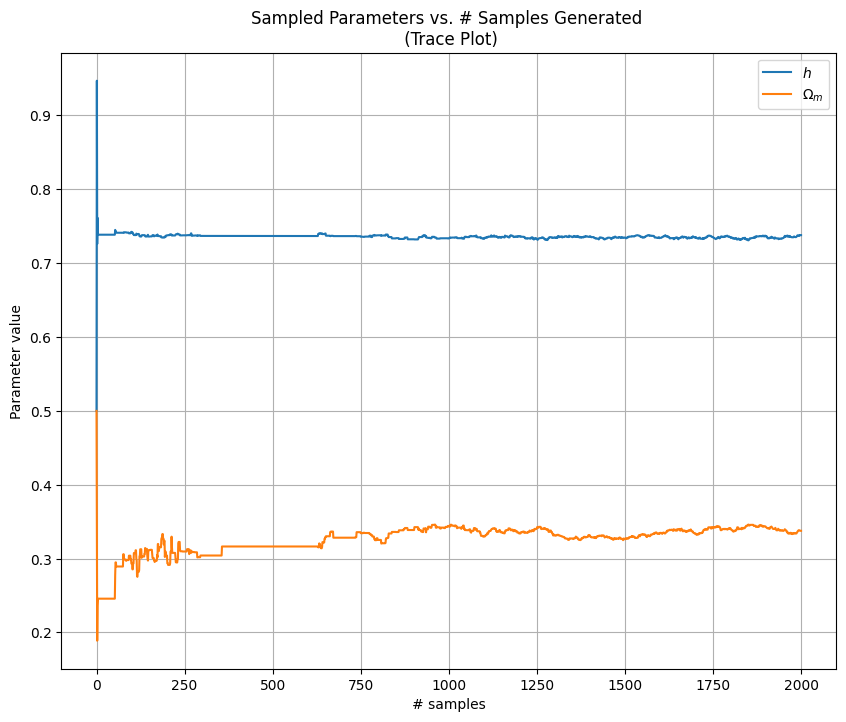

In [86]:
plt.figure(figsize = (10,8))
plt.title('Sampled Parameters vs. # Samples Generated \n (Trace Plot)')
plt.plot(h_samples, label = r'$h$')
plt.plot(omega_samples, label = r'$\Omega_{m}$')
plt.xlabel('# samples')
plt.ylabel('Parameter value')
plt.legend()
plt.grid()
plt.show()
plt.close()

We should check if our adaptive step size scheme has aided in producing appropriate values of the simulated parameters over the entire simulation procedure. Let us consider the behaviour of the acceptance ratios and step sizes over the sampling procedure. We recall that these were calculated on an interval basis, so every `adapt_interval` number of sweeps (every 100 sweeps here). 

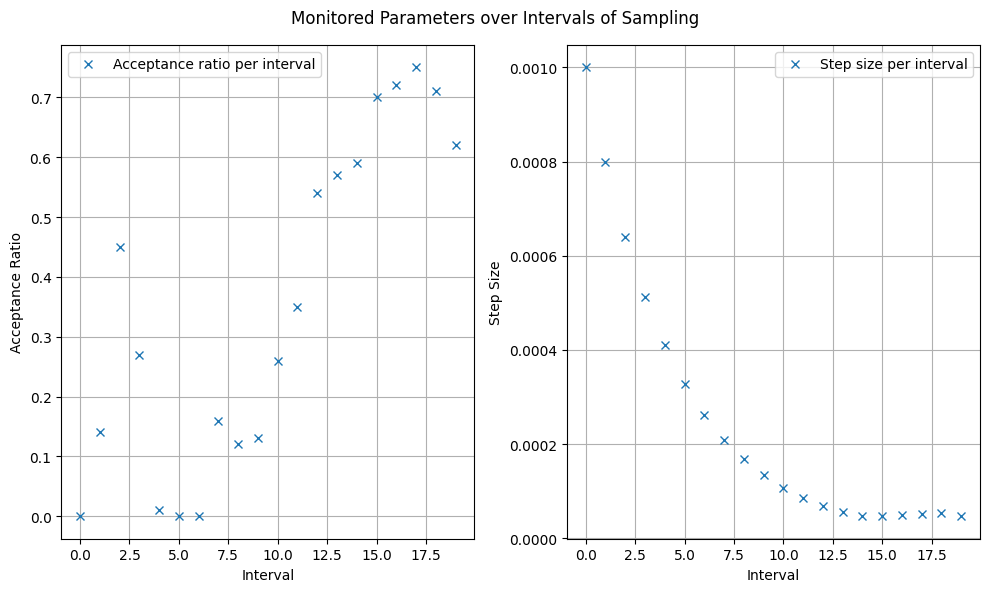

In [87]:
rows, cols = 1, 2
fig, axs = plt.subplots(rows, cols, figsize = (10,6))
fig.suptitle('Monitored Parameters over Intervals of Sampling')
axs = axs.flatten()

axs[0].plot(acceptances, label = 'Acceptance ratio per interval', linestyle = ' ', marker = 'x')
axs[0].set_xlabel('Interval')
axs[0].set_ylabel('Acceptance Ratio')
axs[0].legend()
axs[0].grid()

axs[1].plot(step_size_list, label = 'Step size per interval', linestyle = ' ', marker = 'x')
axs[1].set_xlabel('Interval')
axs[1].set_ylabel('Step Size')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()
plt.close()

Using the optimal step size for 6 leapfrog steps, which we take to be the last value in `step_size_list`, we can re-run the simulation. At this point, the adaptive step size feature should be disabled, as we have determined an estimate for the optimal step size for the current initialisation of the simulation. Disabling the adaptive step size ensures that only constant updates are made to the parameters on each leapfrog iteration, leading to more consistent results.

In [88]:
# Optimal step size for given number of steps
step_size_opt = step_size_list[-1]
print(f'Optimal step size for {num_steps} steps: {step_size_opt}')
# Call the HMC function
h_samples_upd, omega_samples_upd, acceptances_upd, step_size_list_upd = exe_HMC(z, mu, initial_params, 
                                                                                n_samples, step_size_opt, 
                                                                                num_steps, adaptive_steps = False)

Optimal step size for 15 steps: 4.6694127966542165e-05
Final Acceptance Rate: 0.66


We have achieved a final acceptance rate of about 0.7, which is what we wanted.

We should now check how the sample parameters are varying over the duration of the simulation given this initialisation:

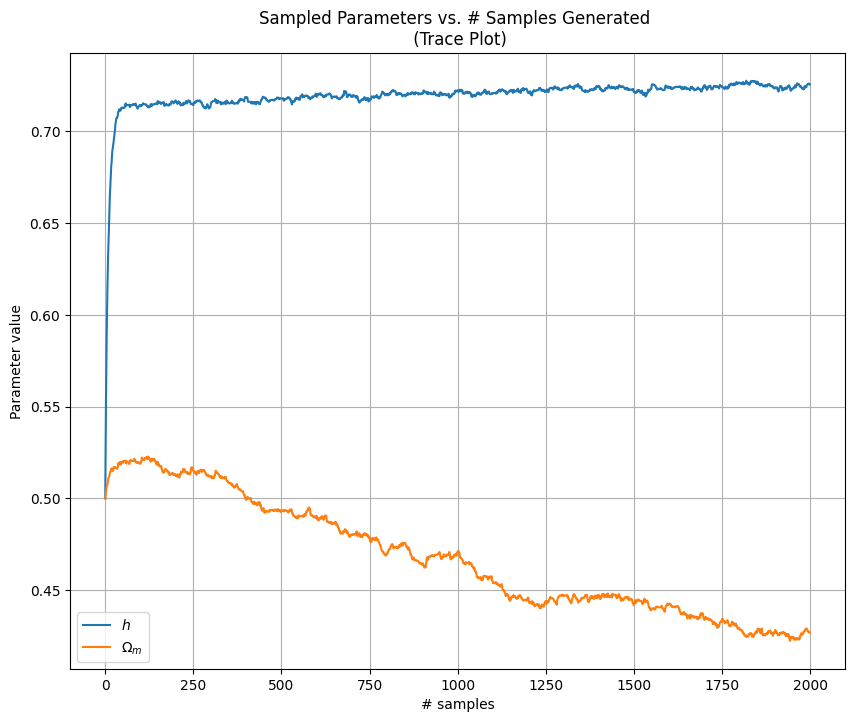

In [89]:
plt.figure(figsize = (10,8))
plt.title('Sampled Parameters vs. # Samples Generated \n (Trace Plot)')
plt.plot(h_samples_upd, label = r'$h$')
plt.plot(omega_samples_upd, label = r'$\Omega_{m}$')
plt.xlabel('# samples')
plt.ylabel('Parameter value')
plt.legend()
plt.grid()
plt.show()
plt.close()

Clearly the sampled values for $h$ have started to level off (more-or-less) but the values of $\Omega_{m}$ have yet to do so. We will need to re-run the simulation with a larger number of samples.

In [90]:
n_samples_upd = 10000 # much larger now

# Call the HMC function, still disable adaptive step sizes
h_samples_upd_2, omega_samples_upd_2, acceptances_upd_2, step_size_list_upd_2 = exe_HMC(z, mu, initial_params, 
                                                                                        n_samples_upd, step_size_opt, 
                                                                                        num_steps, adaptive_steps = False)

Final Acceptance Rate: 0.68


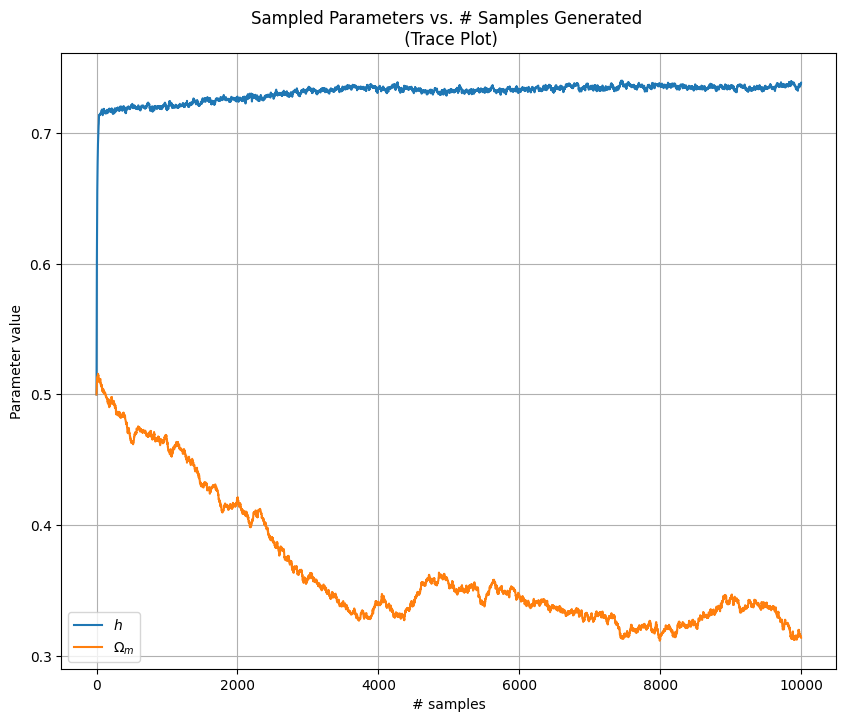

In [91]:
plt.figure(figsize = (10,8))
plt.title('Sampled Parameters vs. # Samples Generated \n (Trace Plot)')
plt.plot(h_samples_upd_2, label = r'$h$')
plt.plot(omega_samples_upd_2, label = r'$\Omega_{m}$')
plt.xlabel('# samples')
plt.ylabel('Parameter value')
plt.legend()
plt.grid()
plt.show()
plt.close()

Here, we observe that the chains have roughly stabilized after generating 4000 samples. While this is true for $h$, it is less evident for $\Omega_m$, which appears to exhibit oscillatory behavior after 4000 steps. We will later investigate the effects of using different initialisation parameters to address this issue. For now, we choose a burn-in of 4000 samples, which we discard. The remaining samples will be used to compute the mean, variance, and covariance of our simulated parameters.

In [122]:
def statistics(chain1, chain2 = None, burn_in = 0):
    mean = np.mean(chain1[burn_in:])
    var = np.var(chain1[burn_in:])
    if chain2 is not None:
        cov = np.cov(chain1[burn_in:], chain2[burn_in:])[0,1]
        return mean, var, cov
    
    return mean, var

In [145]:
burn_in = 4000 # Number of samples to discard

h_stats = statistics(h_samples_upd_2, burn_in = burn_in)
omega_m_stats = statistics(omega_samples_upd_2, burn_in = burn_in)
print(f'h: mean: {h_stats[0].round(4)}, variance: {h_stats[1].round(7)}')
print(f'omega_m: mean: {omega_m_stats[0].round(4)}, variance: {omega_m_stats[1].round(7)}')
print(f'Covariance between h and omega_m: {statistics(h_samples_upd_2, omega_samples_upd_2, burn_in = burn_in)[2].round(7)}')

h: mean: 0.7346, variance: 3.5e-06
omega_m: mean: 0.3359, variance: 0.0001442
Covariance between h and omega_m: -1.55e-05


#### 4.2: (Auto-)Correlations and Effective Sample Sizes

To calculate the correlation functions for our chains (with two parameters), we define a function that computes and displays the correlation functions for each chain.

We note that we have not followed the formula provided in the notes, but instead have chosen to use a method based on Fast Fourier Transforms (FFTs). This approach is equivalent to the one in the notes but is significantly faster.

The time complexity of the formula in the notes is $O(n^{2})$, where $n$ is the number of samples, as it involves an iterative approach to calculating the autocorrelation. In contrast, our implementation using FFTs has a time complexity of $O(n\log⁡_{2}n)$, making it more efficient for larger sample sets.

For the effective sample size, we can use the formula presented in the notes directly.

In [92]:
def autocorrelate(O):
    """
    Compute the autocorrelation for a sample
    using the Fourier transform method, to ensure fast computation.
    """
    #  Compute autocorrelation using FFT
    n = len(O)
    f = np.fft.fft(O - np.mean(O), n*2)
    acf = np.fft.ifft(f * np.conjugate(f))[:n].real
    acf /= acf[0]
    return acf

def effective_sample_size(chain):
    """
    Compute the effective sample size.
    """
    
    acf = autocorrelate(chain)
    
    # Find first negative autocorrelation
    delta_0 = np.argmax(acf < 0)
    
    # Sum autocorrelations up to delta_0
    # Use only positive autocorrelations
    positive_acf = acf[:delta_0]
    ess = len(chain) / (1 + 2 * np.sum(positive_acf))
    return ess

Let us visualise the autocorrelations of the chains and calculate the effective sample sizes (ESS) for each.

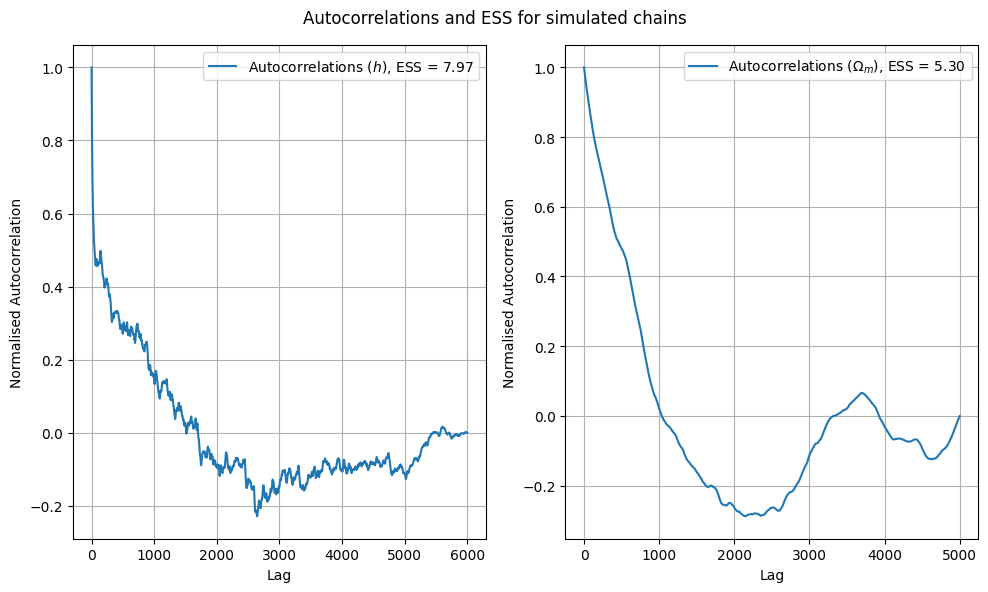

In [93]:
h_auto = autocorrelate(h_samples_upd_2[4000:])
ess_h = effective_sample_size(h_samples_upd_2[4000:])

omega_m_auto = autocorrelate(omega_samples_upd_2[5000:])
ess_omega_m = effective_sample_size(omega_samples_upd_2[5000:])

rows, cols = 1, 2
fig, axs = plt.subplots(rows, cols, figsize = (10,6))
fig.suptitle('Autocorrelations and ESS for simulated chains')
axs = axs.flatten()

axs[0].plot(h_auto, label = r'Autocorrelations $(h)$,'+f' ESS = {ess_h:.2f}')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Normalised Autocorrelation')
axs[0].legend()
axs[0].grid()

axs[1].plot(omega_m_auto, label = r'Autocorrelations $(\Omega_{m})$,'+f' ESS = {ess_omega_m:.2f}')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Normalised Autocorrelation')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()
plt.close()

### Section - 5: More Extensive testing

We now explore a variety of different initialisations for our simulation. We will run a function that will perform the steps of our analysis thus far, and we will feed in different sets of input initialisations.

To save simulation time, we will take the last simulated parameter values from our previous run of 10,000 samples as the initial parameter values for each simulation from now, and only consider a smaller number of further simulations, say, 1000 from this start. We could consider this a sort of 'semi-hot' initialisation for our simulation, since the parameter values already quite close to convergence to a fixed value.

We will use a range of evenly spaced step sizes from, say, 4 to 16 leapfrog steps for a given initial leapfrog step size of $1 \times 10^{-3}$. For each value of leapfrog steps, we will first perform a run to deterimine the approximate optimal step size for each value of the number of leapfrog steps using our adaptive, and then re-run the simulation using the estimated optimal step size. 

Lastly, we will consider the autocorrelation functions for each set of chains and their respective ESS values.

In [186]:
@jit(nopython = True)
def sequencer(initial_params, initial_step_size, num_steps, n_samples):
    print('Number of steps:', num_steps)
    print('Acceptance rate while tuning step sizes:')
    h_samples_, omega_samples_, acceptances_, step_size_list_ = exe_HMC(z, mu, initial_params, 
                                                                        n_samples, initial_step_size, 
                                                                        num_steps, adaptive_steps = True, adapt_interval = 50)
    opt_step_size = step_size_list_[-1]
    acceptance_rate = acceptances_[-1]
    print('\nOptimal step size for:', num_steps, 'steps:', opt_step_size)
    print('New final acceptance:')
    h_samples_, omega_samples_, acceptances_, step_size_list_ = exe_HMC(z, mu, initial_params, 
                                                                        n_samples, opt_step_size, 
                                                                        num_steps, adaptive_steps = False)
    print('\n')
    return h_samples_, omega_samples_, acceptance_rate, opt_step_size

In [187]:
num_steps_list = [4, 7, 10, 13, 16]
initial_params = np.array([h_samples_upd_2[-1], omega_samples_upd_2[-1]])
initial_step_size = 1e-3
n_samples = 1000
hs_list = []
omegas_list = []
accepts_list = []
sizes_list = []
for num_steps in num_steps_list:
    hs, omegas, accepts, sizes = sequencer(initial_params, initial_step_size, num_steps, n_samples)
    print(accepts)
    hs_list.append(hs)
    omegas_list.append(omegas)
    accepts_list.append(accepts)
    sizes_list.append(sizes)

Number of steps: 4
Acceptance rate while tuning step sizes:
Final Acceptance Rate: 0.54

Optimal step size for: 4 steps: 0.00019383237222045534
New final acceptance:
Final Acceptance Rate: 0.64


0.74
Number of steps: 7
Acceptance rate while tuning step sizes:
Final Acceptance Rate: 0.44

Optimal step size for: 7 steps: 8.887265941184041e-05
New final acceptance:
Final Acceptance Rate: 0.74


0.64
Number of steps: 10
Acceptance rate while tuning step sizes:
Final Acceptance Rate: 0.42

Optimal step size for: 10 steps: 8.133391853738815e-05
New final acceptance:
Final Acceptance Rate: 0.65


0.74
Number of steps: 13
Acceptance rate while tuning step sizes:
Final Acceptance Rate: 0.37

Optimal step size for: 13 steps: 4.609318125049209e-05
New final acceptance:
Final Acceptance Rate: 0.69


0.7
Number of steps: 16
Acceptance rate while tuning step sizes:
Final Acceptance Rate: 0.35

Optimal step size for: 16 steps: 4.3211726251503655e-05
New final acceptance:
Final Acceptance Rate: 0.69


Let us check the simulated samples for each set of simulations:

Let us also check the behaviour of the final acceptance rates and approximately optimal step sizes for each set of simulations:

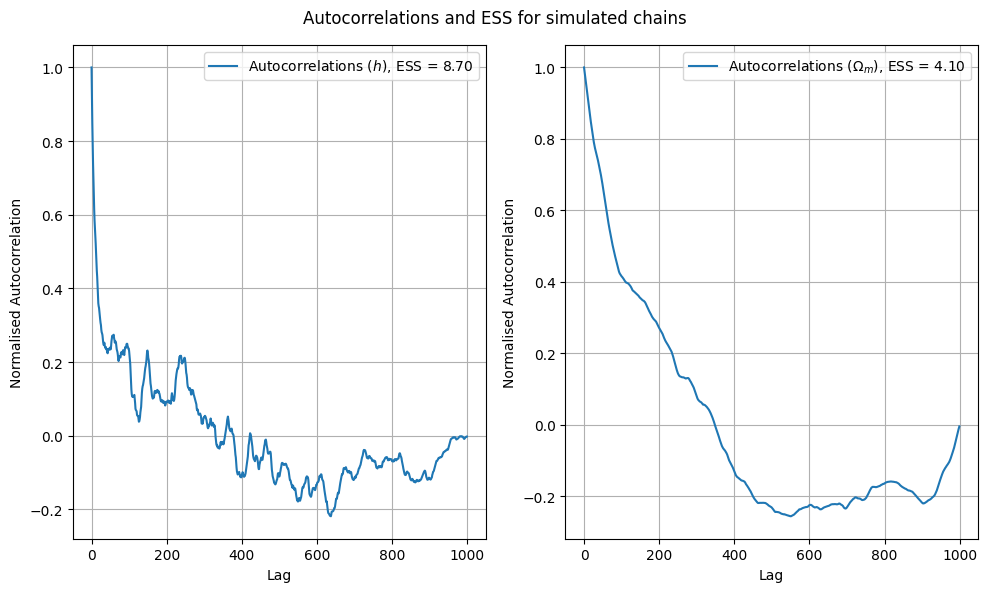

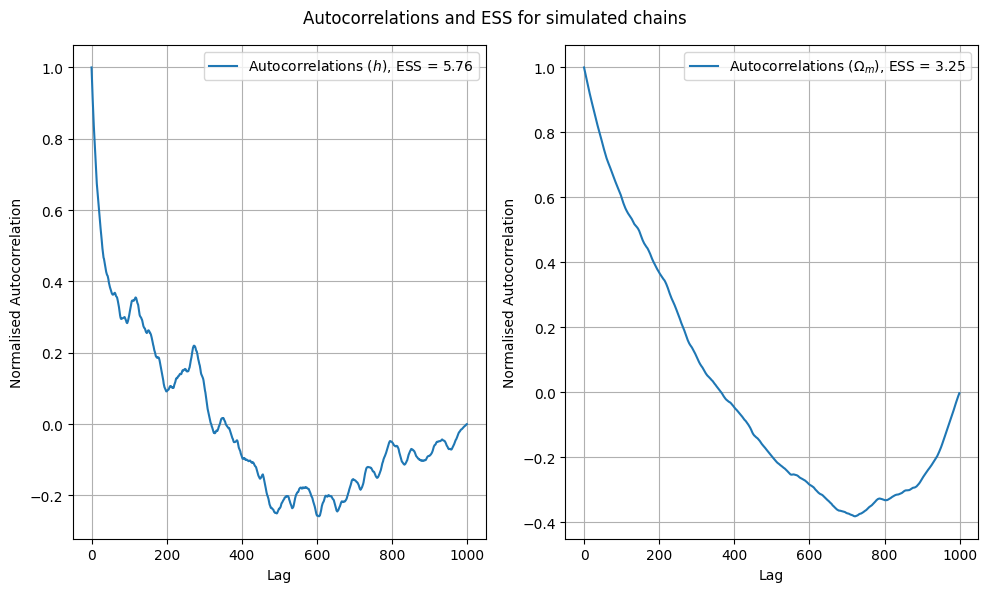

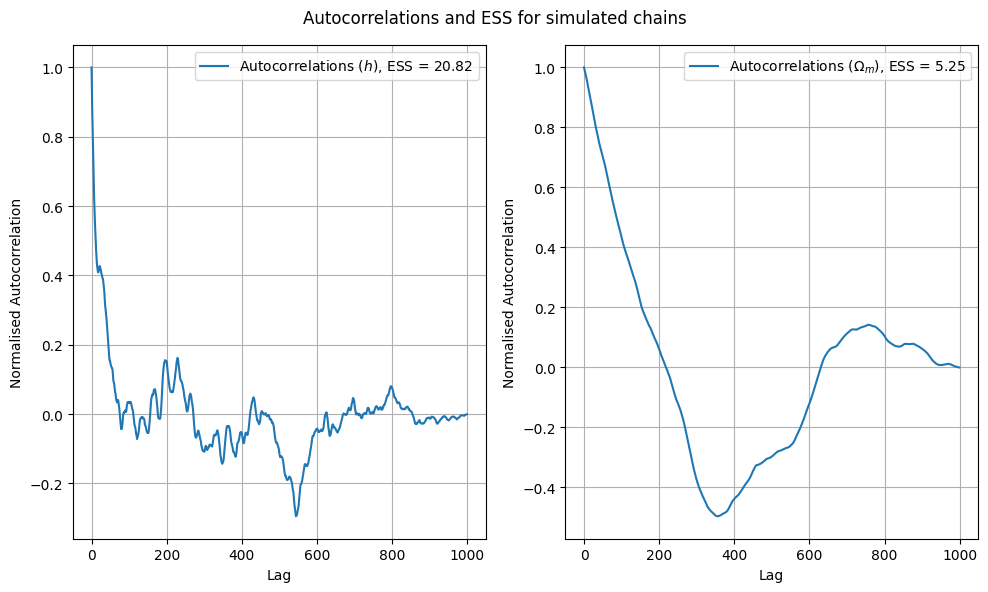

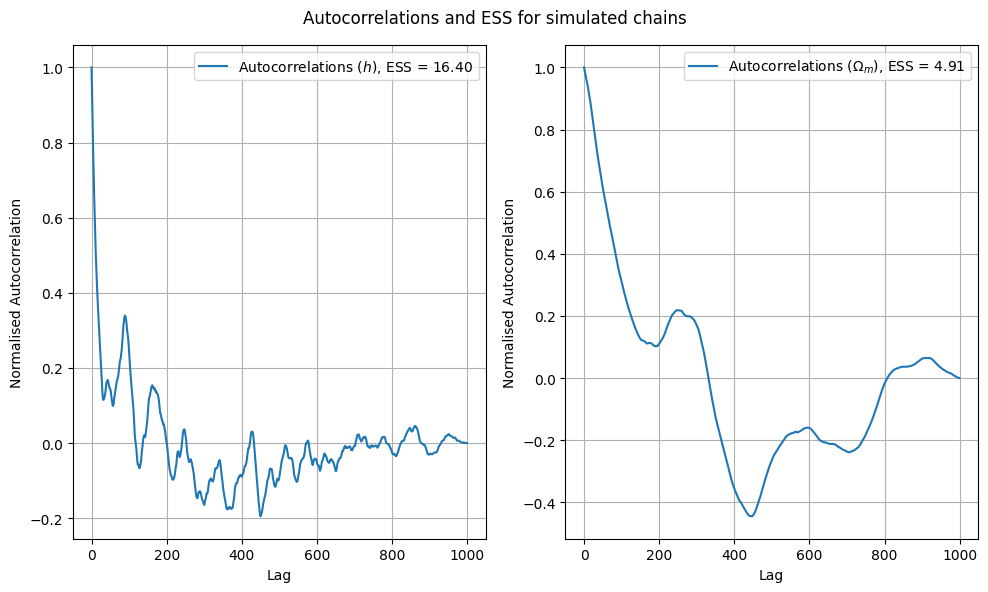

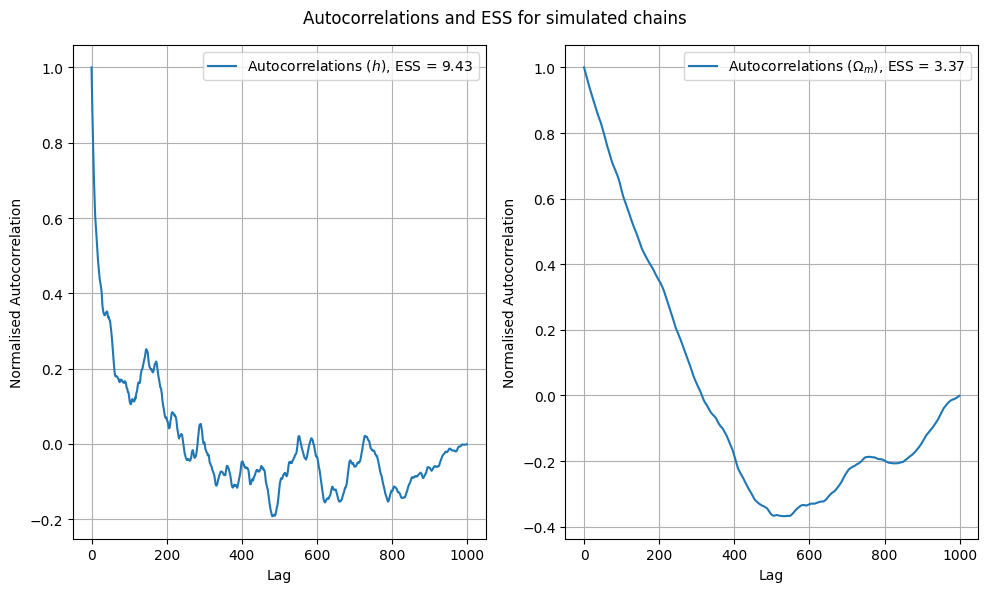

In [193]:
for hs, omegas in zip(hs_list, omegas_list):
    h_auto_ = autocorrelate(hs)
    ess_h_ = effective_sample_size(hs)
    
    omega_m_auto_ = autocorrelate(omegas)
    ess_omega_m_ = effective_sample_size(omegas)

    rows, cols = 1, 2
    fig, axs = plt.subplots(rows, cols, figsize = (10,6))
    fig.suptitle('Autocorrelations and ESS for simulated chains')
    axs = axs.flatten()
    
    axs[0].plot(h_auto_, label = r'Autocorrelations $(h)$,'+f' ESS = {ess_h_:.2f}')
    axs[0].set_xlabel('Lag')
    axs[0].set_ylabel('Normalised Autocorrelation')
    axs[0].legend()
    axs[0].grid()
    
    axs[1].plot(omega_m_auto_, label = r'Autocorrelations $(\Omega_{m})$,'+f' ESS = {ess_omega_m_:.2f}')
    axs[1].set_xlabel('Lag')
    axs[1].set_ylabel('Normalised Autocorrelation')
    axs[1].legend()
    axs[1].grid()
    
    plt.tight_layout()
    plt.show()
    plt.close()

We find that the autocorrelations depend both on the step sizes and the number of steps, which, in turn depend on each other. A larger step size means fewer steps can be taken in the phase space before samples starting getting rejected, and vice versa. However, if the step sizes are too small, the chains take longer to decorrelate.

### Section - 6: Conclusions

To summarise our work, we have conducted a simulation-based Bayesian inference and have implemented the HMC algorithm, incorporating a leapfrog integrator to find the parameters ($h$, $\Omega_{m}$). We found values of $(0.74, 0.34)$, which is in line with other estimates of these parameters that may be found in the literature. 

In our analysis, we included the use of a JIT, an adaptive step size scheme, and autocorrelation calculations by FFTs, which were alternates/additions to the recommended approach. We used these since we have prior experience with coding MCMC algorithms from scratch, where were implemented such techniques.

There is some room for improvement in our approach. We found that the autocorrelations for $\Omega_{m}$ did not seem to decay in the same manner as those for $h$. This might be due to the fact that $h$ and $\Omega_{m}$ have slightly different scales and vary differently with $z$ and $mu_{th}$. As an extension, we recommend trying to incorporating different step sizes for each paramaters to be simulated, and update them in a weighted fashion and investigate if that leads to better autocorrelation behaviour for $\Omega_{m}$.

This brings us the end of this notebook. We have made a repo for this notebook on GitHub for open access to our work.

We declare that some aspects of the code and explanations were polished using a Generative AI (ChatGPT), but the bulk of the work was carried out individually, without the use of AI. The leapfrog symmetry checker for example was a suggestion from ChatGPT and the structure of the explanation in Section-3 was also suggested by AI.